In [1]:
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from sklearn.metrics import accuracy_score
from tensorflow import keras
from sklearn import metrics
import tensorflow as tf
import pandas as pd
import numpy as np
import plotting
import hls4ml
import shap
import sys
import os

np.random.seed(77)

import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.CMS)

/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/hls4ml_instruct_cnn/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [2]:
options = {
    'v'          : '9',
    'date'       : '2022_09_14',
    'inTagIdent' : '_lTauPtCut18',
    'inTagCalib' : '_lTauPtCut18_uEtacut1.5',
    'caloClNxM'  : '5x9',
    'sparsity'   : 0.6
}

In [3]:
indir = '/data_CMS/cms/motta/Phase2L1T/'+options['date']+'_v'+options['v']

N = int(options['caloClNxM'].split('x')[0])
M = int(options['caloClNxM'].split('x')[1])

sparsityTag = str(options['sparsity']).split('.')[0]+'p'+str(options['sparsity']).split('.')[1]

In [4]:
X1_id = np.load(indir+'/TauCNNIdentifier'+options['caloClNxM']+'Training'+options['inTagIdent']+'/X_CNN_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
X2_id = np.load(indir+'/TauCNNIdentifier'+options['caloClNxM']+'Training'+options['inTagIdent']+'/X_Dense_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
Y_id  = np.load(indir+'/TauCNNIdentifier'+options['caloClNxM']+'Training'+options['inTagIdent']+'/Y_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']

X1_id = np.float32(X1_id)
X2_id = np.float32(X2_id)
Y_id = np.float32(Y_id)

X1_id_reduced = X1_id[:3000]
X2_id_reduced = X2_id[:3000]
Y_id_reduced = Y_id[:3000]

In [5]:
X1_cal = np.load(indir+'/TauCNNCalibrator'+options['caloClNxM']+'Training'+options['inTagCalib']+'/X_CNN_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
X2_cal = np.load(indir+'/TauCNNCalibrator'+options['caloClNxM']+'Training'+options['inTagCalib']+'/X_Dense_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
Y_cal  = np.load(indir+'/TauCNNCalibrator'+options['caloClNxM']+'Training'+options['inTagCalib']+'/Y_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']

X1_cal = np.float32(X1_cal)
X2_cal = np.float32(X2_cal)
Y_cal = np.float32(Y_cal)

X1_cal_reduced = X1_cal[:3000]
X2_cal_reduced = X2_cal[:3000]
Y_cal_reduced = Y_cal[:3000]

In [6]:
# quantized and pruned models
QCNN = keras.models.load_model(indir+'/TauCNNIdentifier'+options['caloClNxM']+'Training'+options['inTagIdent']+'/QCNNmodel'+sparsityTag+'Pruned', compile=False)
QDNNident = keras.models.load_model(indir+'/TauCNNIdentifier'+options['caloClNxM']+'Training'+options['inTagIdent']+'/QDNNmodel'+sparsityTag+'Pruned', compile=False)
QDNNcalib = keras.models.load_model(indir+'/TauCNNCalibrator'+options['caloClNxM']+'Training'+options['inTagCalib']+'/TauCNNQCalibrator'+sparsityTag+'Pruned', compile=False)

2022-09-25 10:48:39.768780: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /grid_mnt/opt__exp_soft/llr/python/3.9.9/lib/python3.9/site-packages/cv2/../../lib64:/opt/exp_soft/llr/python/3.9.9/lib/vtk:/opt/exp_soft/llr/python/3.9.9/lib:/usr/lib64/classads:/usr/lib64:/usr/lib
2022-09-25 10:48:39.768815: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-09-25 10:48:39.769858: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) t

In [7]:
# original floating point model without pruning
CNN_FullFloat= keras.models.load_model(indir+'/TauCNNIdentifier'+options['caloClNxM']+'Training'+options['inTagIdent']+'/CNNmodel', compile=False)
DNNident_FullFloat= keras.models.load_model(indir+'/TauCNNIdentifier'+options['caloClNxM']+'Training'+options['inTagIdent']+'/DNNmodel', compile=False)
DNNcalib_FullFloat= keras.models.load_model(indir+'/TauCNNCalibrator'+options['caloClNxM']+'Training'+options['inTagCalib']+'/TauCNNCalibrator', compile=False)

# QUANTIZED MODELS ONLY

## Create HLS model for the identification CNN and DNN - QUANTIZED

Interpreting Model
Topology:
Layer name: TowerClusterImage, layer type: Input
Layer name: CNNpBNlayer1, layer type: QConv2DBatchnorm
  -> Activation (linear), layer name: CNNpBNlayer1
Layer name: RELU_CNNpBNlayer1, layer type: QActivation
  -> Activation (quantized_relu(10,7)), layer name: RELU_CNNpBNlayer1
Layer name: MP_CNNpBNlayer1, layer type: MaxPooling2D
Layer name: CNNpBNlayer2, layer type: QConv2DBatchnorm
  -> Activation (linear), layer name: CNNpBNlayer2
Layer name: RELU_CNNpBNlayer2, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_CNNpBNlayer2
Layer name: TowerClusterPosition, layer type: Input
Layer name: middleMan, layer type: Concatenate
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'TowerClusterImage': {'Precision': 'ap_fixed<16,9>', 'Strategy': 'Latency', 'ReuseFactor': 1, 'Trace': True}, 'CNNpBNlayer1': {'Precision': 'ap_fixed<16,7>', 'ReuseFactor': 1, 'Strategy': 'Latency', 'Trace': Tr

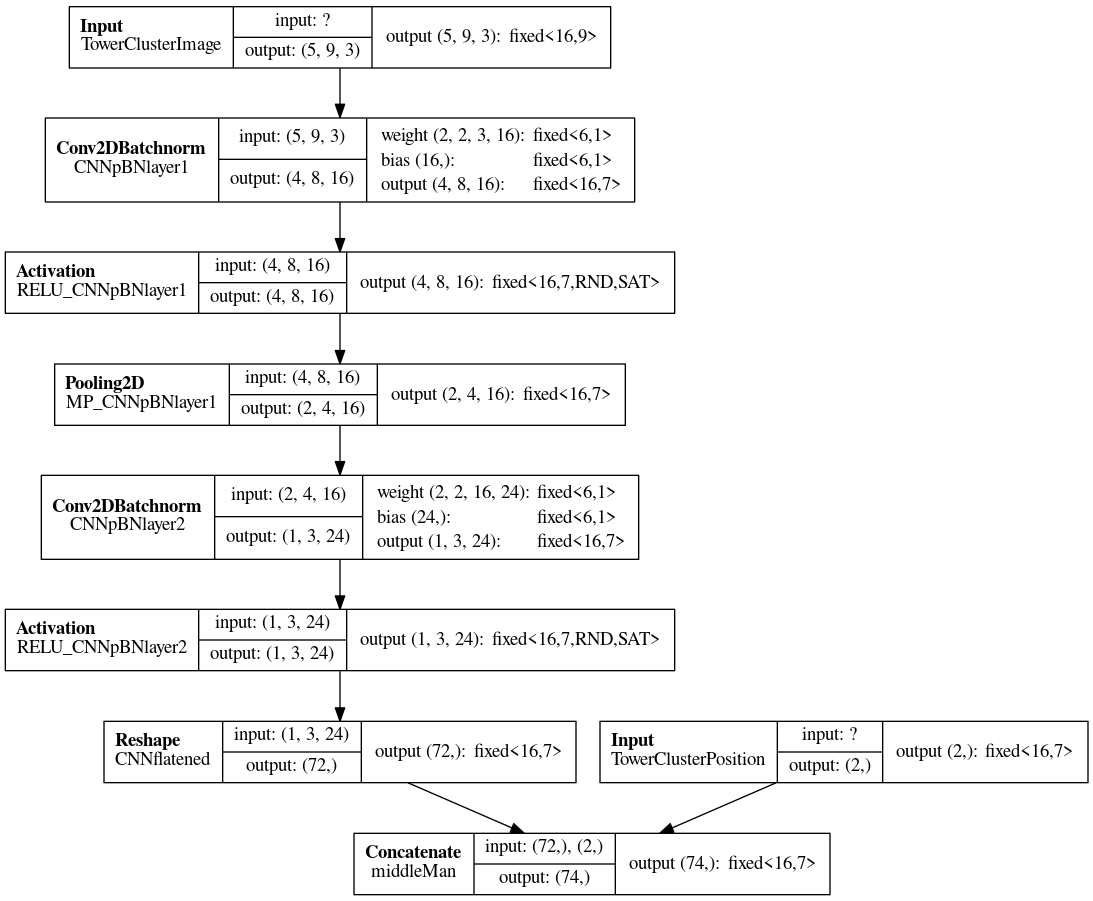

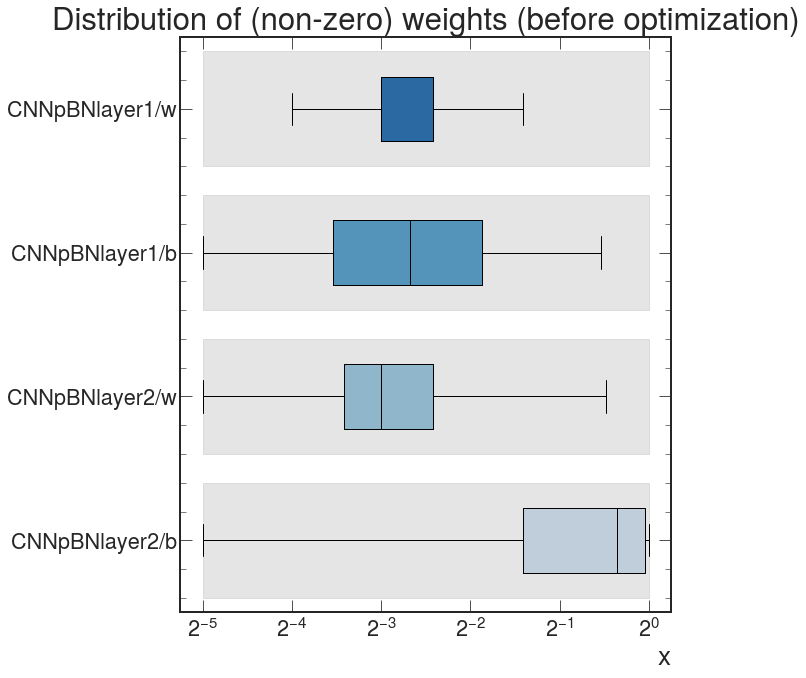

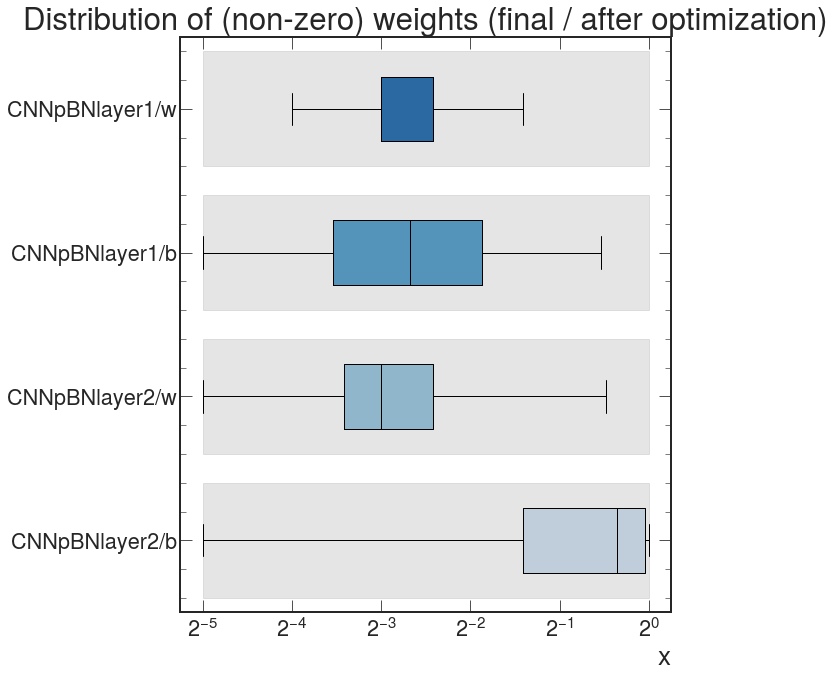

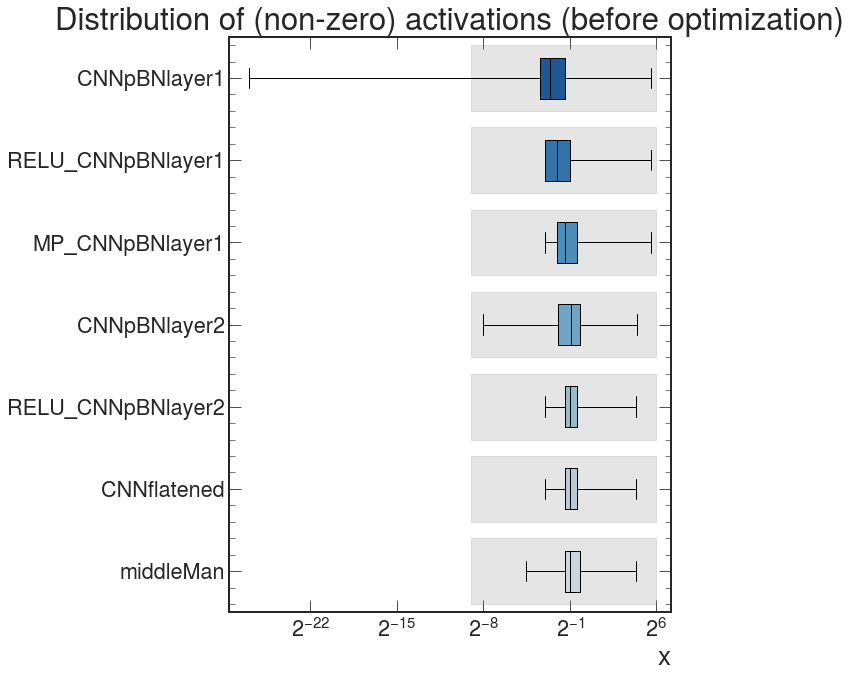

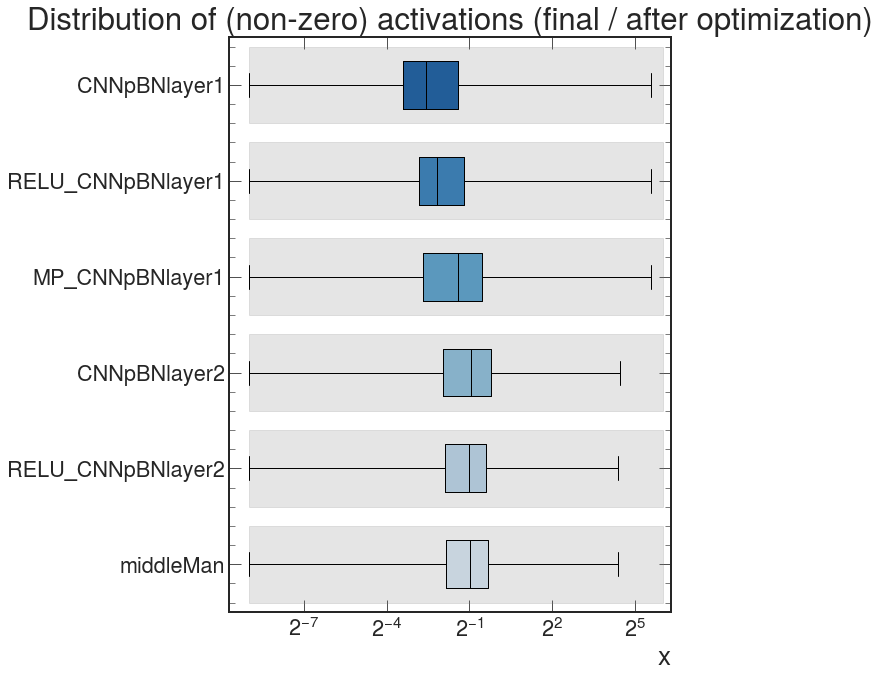

In [8]:
############################## Pass quantized CNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
QCNN_hls_cfg = hls4ml.utils.config_from_keras_model(QCNN, granularity='name')
QCNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
QCNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in QCNN_hls_cfg['LayerName'].keys():
    QCNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Latency'
    QCNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    QCNN_hls_cfg['LayerName'][Layer]['Trace'] = True
    QCNN_hls_cfg['LayerName'][Layer]['Precision'] = 'ap_fixed<16,7>'

QCNN_hls_cfg['LayerName']['TowerClusterImage']['Precision'] = 'ap_fixed<16,9>'
QCNN_hls_cfg['LayerName']['middleMan']['Strategy'] = 'Stable'

print(QCNN_hls_cfg)

QCNN_cfg = hls4ml.converters.create_config(backend='Vivado')
QCNN_cfg['IOType']     = 'io_parallel' # Must set this if using CNNs!
QCNN_cfg['HLSConfig']  = QCNN_hls_cfg
QCNN_cfg['KerasModel'] = QCNN
QCNN_cfg['OutputDir']  = 'QCNN'+sparsityTag+'Pruned/'
QCNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
QCNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

QCNN_hls = hls4ml.converters.keras_to_hls(QCNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QCNN_hls.compile()

hls4ml.model.profiling.numerical(model=QCNN, hls_model=QCNN_hls, X=[X1_id_reduced,X2_id_reduced])
hls4ml.utils.plot_model(QCNN_hls, show_shapes=True, show_precision=True, to_file=None)

Interpreting Model
Topology:
Layer name: CNNflattened, layer type: Input
Layer name: DNNlayer1, layer type: QDense
  -> Activation (linear), layer name: DNNlayer1
Layer name: RELU_DNNlayer1, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_DNNlayer1
Layer name: DNNlayer2, layer type: QDense
  -> Activation (linear), layer name: DNNlayer2
Layer name: RELU_DNNlayer2, layer type: QActivation
  -> Activation (quantized_relu(8,5)), layer name: RELU_DNNlayer2
Layer name: DNNout, layer type: QDense
  -> Activation (linear), layer name: DNNout
Layer name: sigmoid_DNNout, layer type: Activation
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'CNNflattened': {'Precision': 'ap_fixed<16,7>', 'Strategy': 'Latency', 'ReuseFactor': 1, 'Trace': True}, 'DNNlayer1': {'Precision': 'ap_fixed<16,7>', 'ReuseFactor': 1, 'Strategy': 'Latency', 'Trace': True}, 'DNNlayer1_linear': {'Precision': 'ap_fixed<16,7>', 'ReuseFactor': 1, '

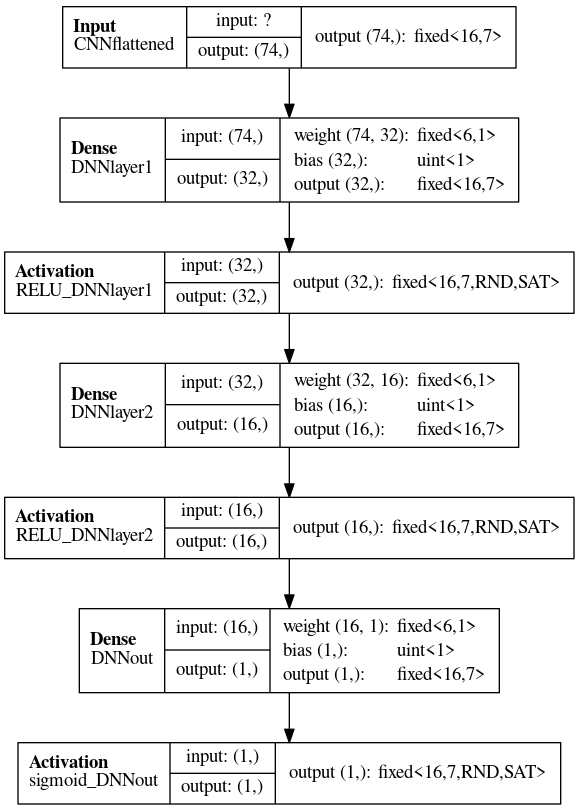

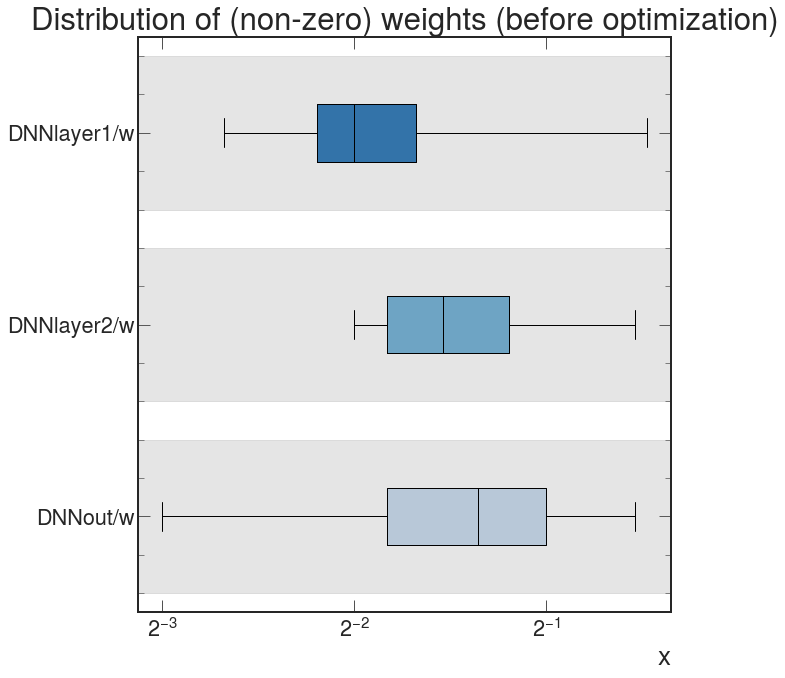

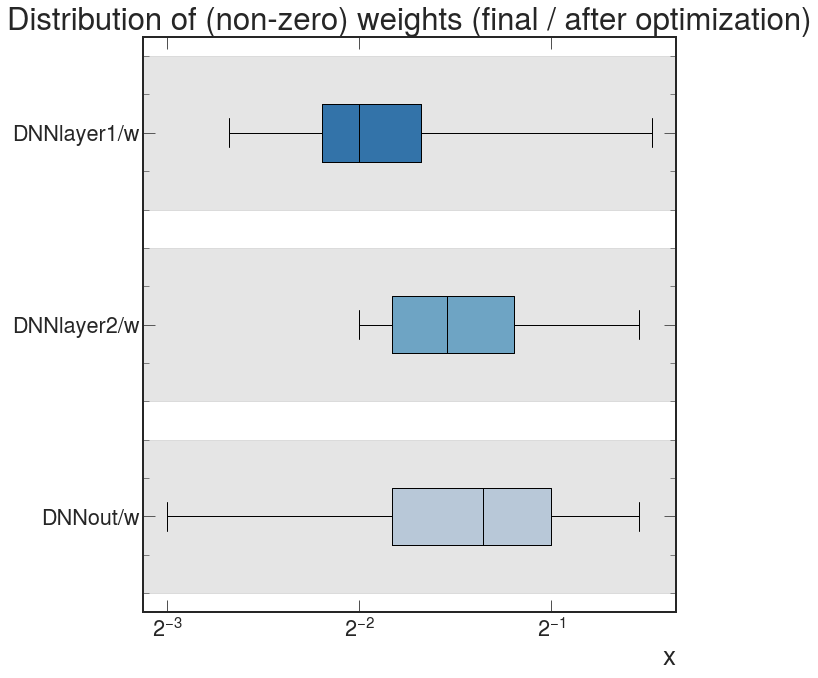

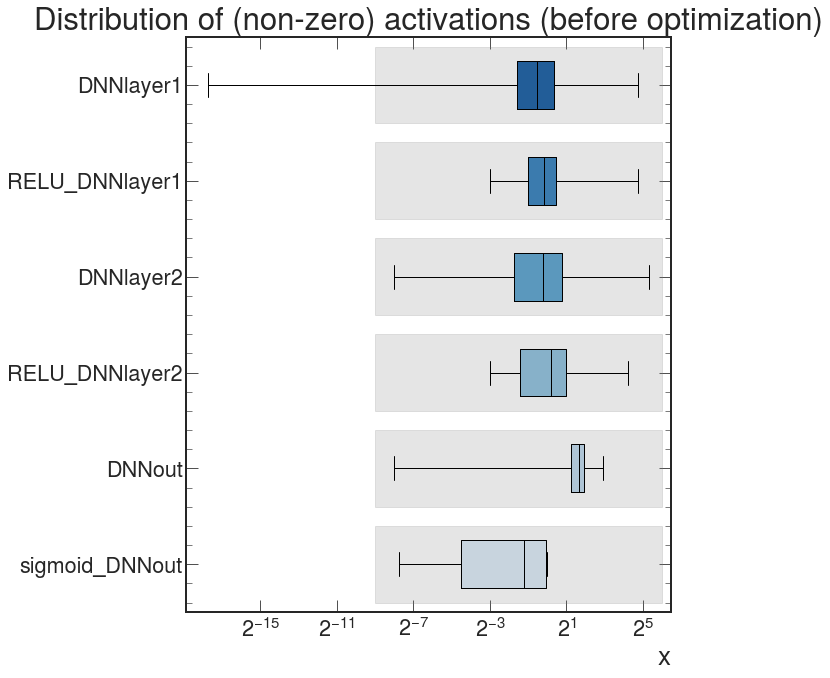

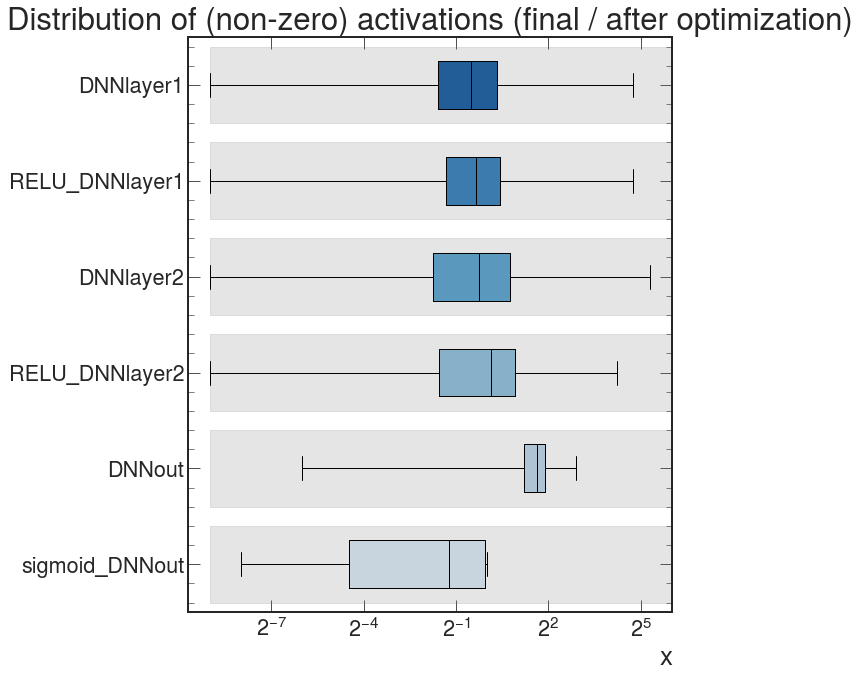

In [9]:
############################## Pass quantized identification DNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
id_QDNN_hls_cfg = hls4ml.utils.config_from_keras_model(QDNNident, granularity='name')
id_QDNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
id_QDNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in id_QDNN_hls_cfg['LayerName'].keys():
    id_QDNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Latency'
    id_QDNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    id_QDNN_hls_cfg['LayerName'][Layer]['Trace'] = True
    id_QDNN_hls_cfg['LayerName'][Layer]['Precision'] = 'ap_fixed<16,7>'
id_QDNN_hls_cfg['LayerName']['sigmoid_DNNout']['Strategy'] = 'Stable'

print(id_QDNN_hls_cfg)

id_QDNN_cfg = hls4ml.converters.create_config(backend='Vivado')
id_QDNN_cfg['IOType']     = 'io_parallel'
id_QDNN_cfg['HLSConfig']  = id_QDNN_hls_cfg
id_QDNN_cfg['KerasModel'] = QDNNident
id_QDNN_cfg['OutputDir']  = 'QDNNident'+sparsityTag+'Pruned/'
id_QDNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
id_QDNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

QDNNident_hls = hls4ml.converters.keras_to_hls(id_QDNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QDNNident_hls.compile()

id_QCNNoutput = np.array(QCNN([X1_id_reduced,X2_id_reduced]))

hls4ml.model.profiling.numerical(model=QDNNident, hls_model=QDNNident_hls, X=id_QCNNoutput)
hls4ml.utils.plot_model(QDNNident_hls, show_shapes=True, show_precision=True, to_file=None)

## Create HLS model for the calibration DNN - QUANTIZED

Interpreting Model
Topology:
Layer name: CNNflattened, layer type: Input
Layer name: DNNlayer1, layer type: QDense
  -> Activation (linear), layer name: DNNlayer1
Layer name: RELU_DNNlayer1, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_DNNlayer1
Layer name: DNNlayer2, layer type: QDense
  -> Activation (linear), layer name: DNNlayer2
Layer name: RELU_DNNlayer2, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_DNNlayer2
Layer name: DNNout, layer type: QDense
  -> Activation (linear), layer name: DNNout
{'Model': {'Precision': 'ap_fixed<20,9>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'CNNflattened': {'Precision': 'ap_fixed<16,7>', 'Strategy': 'Resources', 'ReuseFactor': 1, 'Trace': True}, 'DNNlayer1': {'Precision': {'weight': 'ap_fixed<6,2>', 'result': 'ap_fixed<18,7>'}, 'ReuseFactor': 1, 'Strategy': 'Resources', 'Trace': True}, 'DNNlayer1_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_si

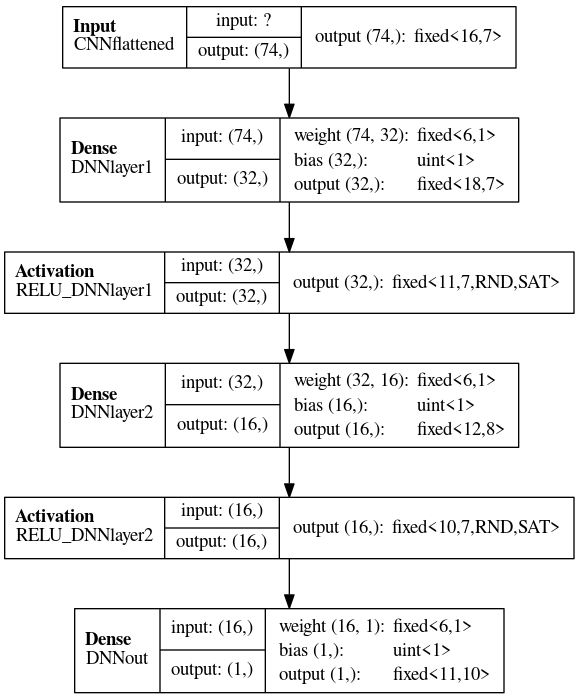

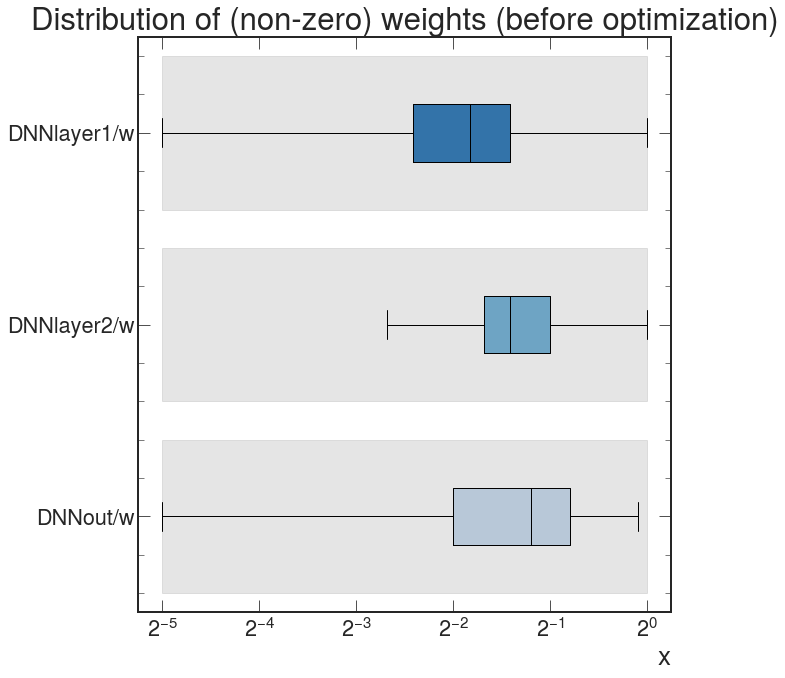

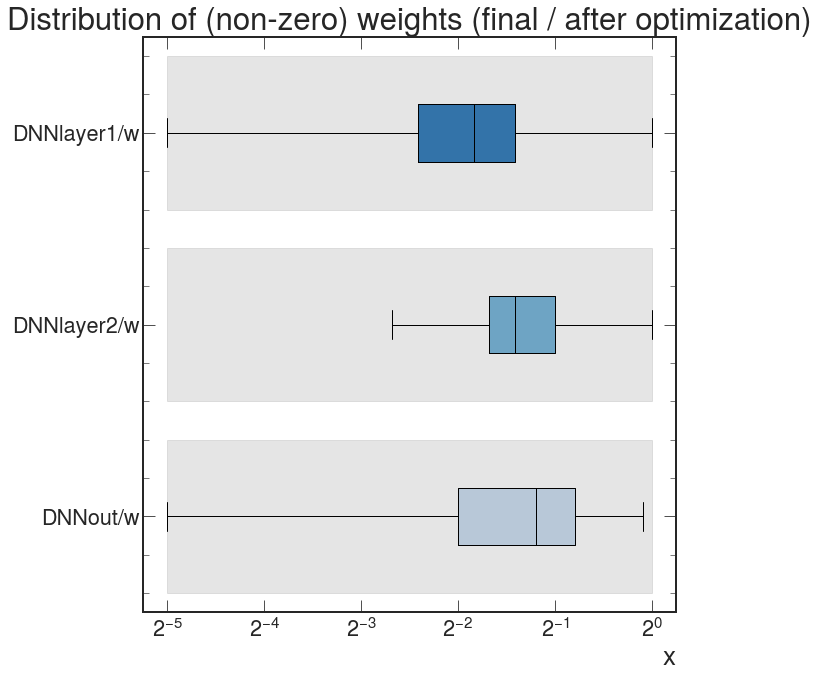

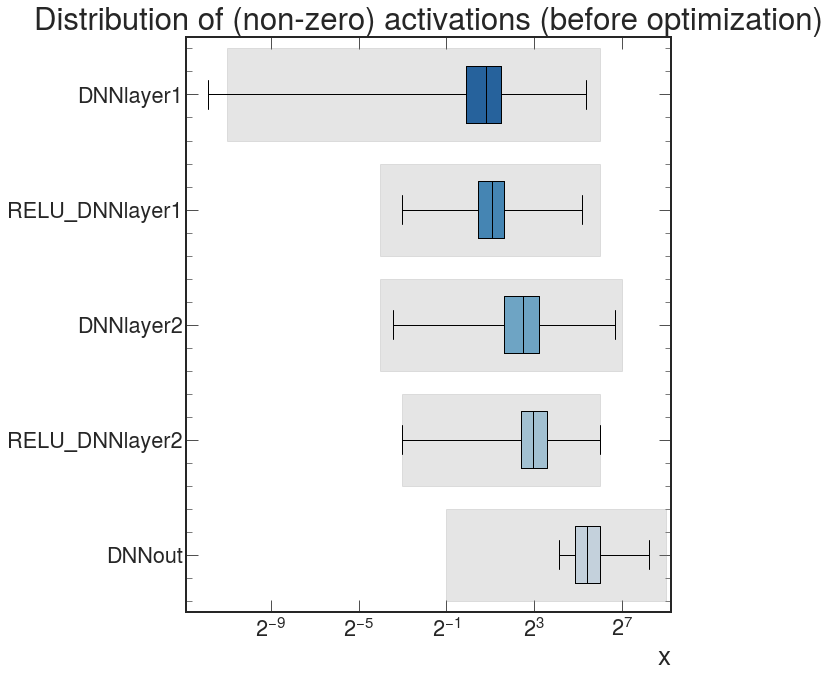

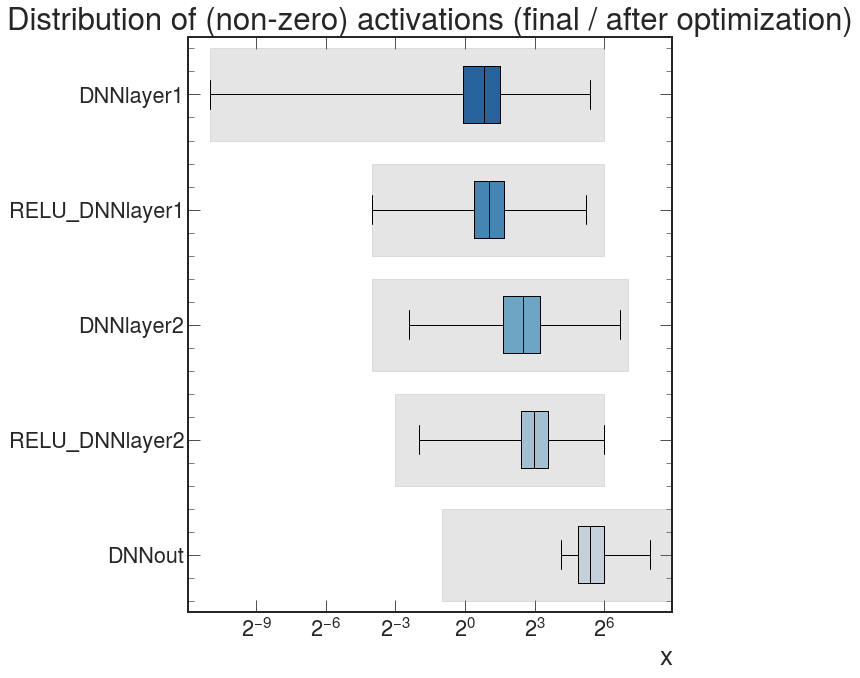

In [10]:
############################## Pass quantized calibration DNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
cal_QDNN_hls_cfg = hls4ml.utils.config_from_keras_model(QDNNcalib, granularity='name')
cal_QDNN_hls_cfg['Model']['Precision'] = 'ap_fixed<20,9>'
cal_QDNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in cal_QDNN_hls_cfg['LayerName'].keys():
    cal_QDNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Resources'
    cal_QDNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    cal_QDNN_hls_cfg['LayerName'][Layer]['Trace'] = True

cal_QDNN_hls_cfg['LayerName']['CNNflattened']['Precision'] = 'ap_fixed<16,7>'
    
cal_QDNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['weight'] = 'ap_fixed<6,2>'
cal_QDNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['result'] = 'ap_fixed<18,7>'
cal_QDNN_hls_cfg['LayerName']['RELU_DNNlayer1']['Precision'] = 'ap_fixed<11,7>'

cal_QDNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['weight'] = 'ap_fixed<6,2>'
cal_QDNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['result'] = 'ap_fixed<12,8>'
cal_QDNN_hls_cfg['LayerName']['RELU_DNNlayer2']['Precision'] = 'ap_fixed<10,7>'

cal_QDNN_hls_cfg['LayerName']['DNNout']['Precision']['weight'] = 'ap_fixed<6,1>'
cal_QDNN_hls_cfg['LayerName']['DNNout']['Precision']['result'] = 'ap_fixed<11,10>'
cal_QDNN_hls_cfg['LayerName']['DNNout']['Strategy'] = 'Stable'

print(cal_QDNN_hls_cfg)

cal_QDNN_cfg = hls4ml.converters.create_config(backend='Vivado')
cal_QDNN_cfg['IOType']     = 'io_stream'
cal_QDNN_cfg['HLSConfig']  = cal_QDNN_hls_cfg
cal_QDNN_cfg['KerasModel'] = QDNNcalib
cal_QDNN_cfg['OutputDir']  = 'QDNNcalib'+sparsityTag+'Pruned/'
cal_QDNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
cal_QDNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

QDNNcalib_hls = hls4ml.converters.keras_to_hls(cal_QDNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QDNNcalib_hls.compile()

cal_QCNNoutput = np.array(QCNN([X1_cal_reduced,X2_cal_reduced]))

hls4ml.model.profiling.numerical(model=QDNNcalib, hls_model=QDNNcalib_hls, X=cal_QCNNoutput)
hls4ml.utils.plot_model(QDNNcalib_hls, show_shapes=True, show_precision=True, to_file=None)

# COMPARE HLS TO KERAS AND QKERAS MODELS

In [30]:
def plotROC(Y, y_pred, y_pred_hls4ml, y_pred_fullfloat, label="Model", Xrange=None, Yrange=None, Yscale=None):
    
    # accuracy_keras  = float(accuracy_score(np.argmax(Y,axis=1), np.argmax(y_pred,axis=1), normalize=True))
    # accuracy_hls4ml = float(accuracy_score(np.argmax(Y,axis=1), np.argmax(y_pred_hls4ml,axis=1), normalize=True))
    # print("Accuracy Keras:  {}".format(accuracy_keras))
    # print("Accuracy hls4ml: {}".format(accuracy_hls4ml))
    
    fig, ax = plt.subplots(figsize=(10, 10))

    FPR, TPR, THR = metrics.roc_curve(Y, y_pred)
    AUC = metrics.roc_auc_score(Y, y_pred)
    
    FPR_HLS, TPR_HLS, THR_HLS = metrics.roc_curve(Y, y_pred_hls4ml)
    AUC_HLS = metrics.roc_auc_score(Y, y_pred_hls4ml)
    
    FPR_FF, TPR_FF, THR_FF = metrics.roc_curve(Y, y_pred_fullfloat)
    AUC_FF = metrics.roc_auc_score(Y, y_pred_fullfloat)
    
    plt.plot(TPR_FF, FPR_FF, label='Keras Full Float ROC, AUC = %.3f' % (AUC_FF), color='red',lw=2)
    plt.plot(TPR, FPR, label=label+' ROC, AUC = %.3f' % (AUC),   color='blue',lw=2)
    plt.plot(TPR_HLS, FPR_HLS, label='HLS ROC, AUC = %.3f' % (AUC_HLS), color='green',lw=2)
    
    plt.legend(loc = 'upper left', fontsize=16)
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Efficiency')
    plt.grid(linestyle=':')
    if Xrange: plt.xlim(Xrange)
    if Yrange: plt.ylim(Yrange)
    if Yscale: plt.yscale(Yscale)
    mplhep.cms.label('Phase-2 Simulation', data=True, rlabel='14 TeV, 200 PU')

In [12]:
y_ident_ff = DNNident_FullFloat.predict(CNN_FullFloat.predict([X1_id, X2_id]))
y_calib_ff = DNNcalib_FullFloat.predict(CNN_FullFloat.predict([X1_cal, X2_cal]))

In [13]:
y_ident_q        = QDNNident.predict(QCNN.predict([X1_id, X2_id]))
y_ident_hls4ml_q = QDNNident_hls.predict(QCNN_hls.predict([X1_id, X2_id]))

In [14]:
y_calib_q        = QDNNcalib.predict(QCNN.predict([X1_cal, X2_cal]))
y_calib_hls4ml_q = QDNNcalib_hls.predict(QCNN_hls.predict([X1_cal, X2_cal]))

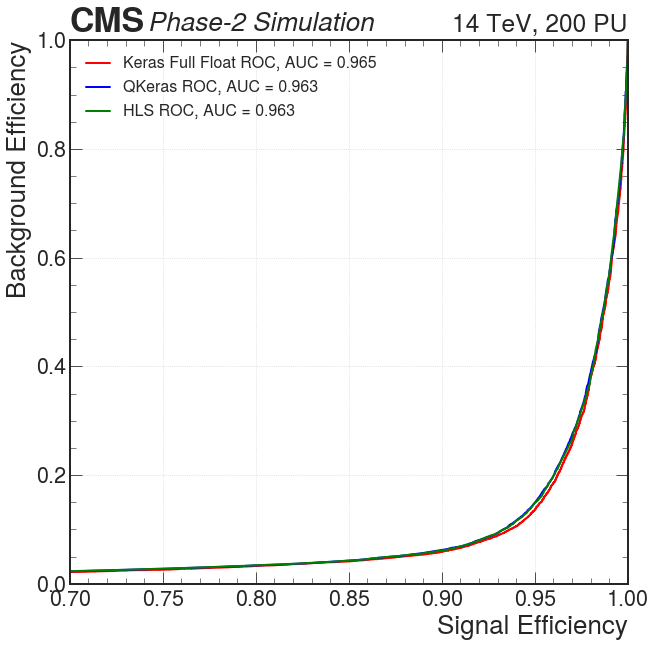

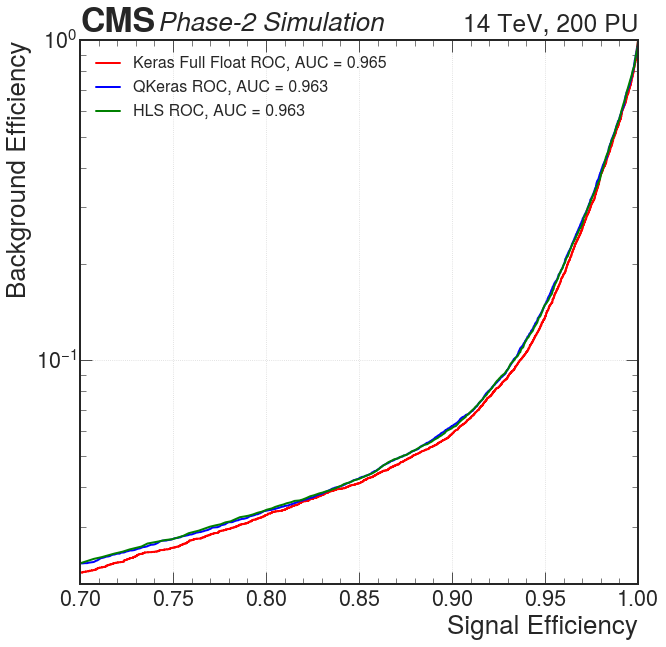

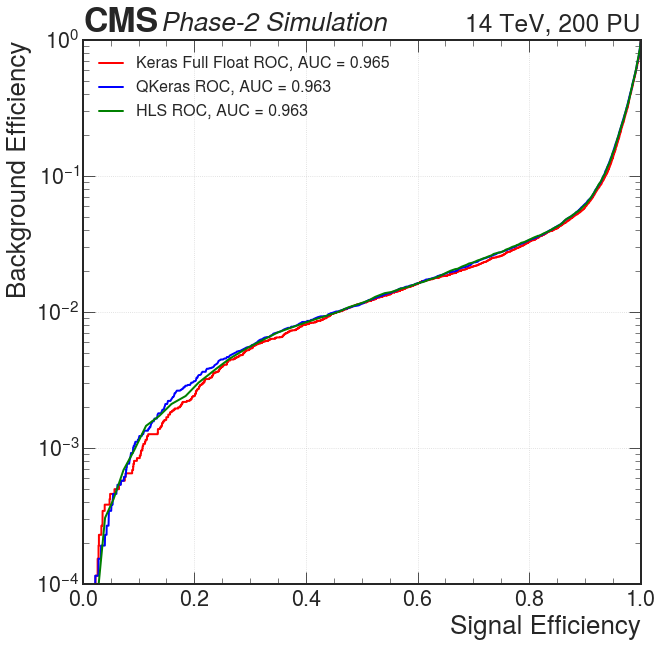

In [31]:
plotROC(Y_id,y_ident_q,y_ident_hls4ml_q, y_ident_ff, label="QKeras", Xrange=(0.7,1), Yrange=(0,1))
plotROC(Y_id,y_ident_q,y_ident_hls4ml_q, y_ident_ff, label="QKeras", Yscale="log", Xrange=(0.7,1), Yrange=(0.02,1))
plotROC(Y_id,y_ident_q,y_ident_hls4ml_q, y_ident_ff, label="QKeras", Yscale="log", Xrange=(0.,1), Yrange=(0.0001,1))

In [16]:
ravelled = Y_cal[:,0]

response_q = y_calib_q.ravel() / ravelled
response_q_hls4ml = y_calib_hls4ml_q.ravel() / ravelled
response_ff = y_calib_ff.ravel() / ravelled

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Phase-2 Simulation'))

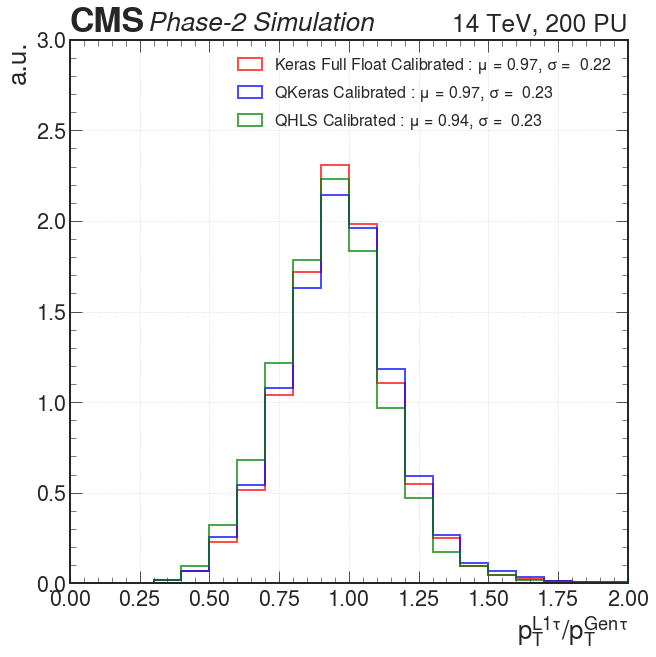

In [17]:
plt.figure(figsize=(10,10))
plt.hist(response_ff,       bins=np.arange(0,5,0.1), label=r'Keras Full Float Calibrated : $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_ff), np.std(response_ff)), color='red', lw=2, density=True, histtype='step', alpha=0.7)
plt.hist(response_q,        bins=np.arange(0,5,0.1), label=r'QKeras Calibrated : $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_q), np.std(response_q)), color='blue', lw=2, density=True, histtype='step', alpha=0.7)
plt.hist(response_q_hls4ml, bins=np.arange(0,5,0.1), label=r'QHLS Calibrated : $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_q_hls4ml), np.std(response_q_hls4ml)), color='green', lw=2, density=True, histtype='step', alpha=0.7)
plt.xlabel(r'$p_{T}^{L1 \tau} / p_{T}^{Gen \tau}$')
plt.ylabel(r'a.u.')
plt.xlim(0., 2.)
plt.ylim(0., 3.)
plt.legend(loc = 'upper right', fontsize=16)
plt.grid(linestyle='dotted')
mplhep.cms.label('Phase-2 Simulation', data=True, rlabel='14 TeV, 200 PU')

In [18]:
synth = False
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    QCNN_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Sun Sep 25 10:50:04 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QCNN0p6Pruned'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/grid_mnt/vol_home/llr/cms/motta/Phase2

INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:25 ; elapsed = 00:00:29 . Memory (MB): peak = 1119.492 ; gain = 597.402 ; free physical = 233353 ; free virtual = 370868
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::concatenate1d<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config9>' (firmware/nnet_utils/nnet_merge.h:170:44).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, relu_config6>' (firmware/nnet_utils/nnet_activation.h:66:39).
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'PartitionLoop' (firmware/nnet_utils/nnet_conv2d_latency.h:196) in function 'nnet::conv_2d_cl<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>' for pipelining.
IN

INFO: [XFORM 203-101] Partitioning array 'data_buf.i'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'mult.V' (firmware/nnet_utils/nnet_conv2d_latency.h:183) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'acc.V' (firmware/nnet_utils/nnet_conv2d_latency.h:186) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'w5.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b5.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'pool.V' (firmware/nnet_utils/nnet_pooling.h:228) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'data_buf.i'  in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'data_buf.i'  in dimension 2 completely.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEE

INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:03:05 ; elapsed = 00:03:10 . Memory (MB): peak = 3105.277 ; gain = 2583.188 ; free physical = 232248 ; free virtual = 369768
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'fill_buffer_1' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'fill_buffer.1'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 2.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 190.79 seconds; current allocated memory: 780.988 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource

INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 7.21 seconds; current allocated memory: 965.696 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config6_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'relu<ap_fixed,ap_fixed<16,7,0,0,0>,relu_config6>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 6.43 seconds; current allocated memory: 967.820 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-

INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_31_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_32_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_33_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_34_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_35_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_36_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_37_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_38_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_39_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_40_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproj

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_44_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_45_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_46_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_47_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_48_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_49_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_50_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_51_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_52_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_53_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_132_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_133_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_134_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_135_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_136_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_137_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_138_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_139_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_140_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_141_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_219_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_220_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_221_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_222_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_223_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_224_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_225_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_226_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_227_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_228_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_304_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_305_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_306_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_307_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_308_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_309_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_310_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_311_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_312_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_313_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_391_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_392_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_393_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_394_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_395_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_396_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_397_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_398_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_399_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_400_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_478_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_479_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_480_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_481_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_482_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_483_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_484_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_485_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_486_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_487_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_52_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_53_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_54_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_55_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_56_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_57_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_58_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_59_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_60_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_61_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_140_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_141_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_142_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_143_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_144_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_145_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_146_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_147_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_148_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_149_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_225_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_226_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_227_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_228_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_229_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_230_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_231_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_232_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_233_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_234_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_311_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_312_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_313_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_314_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_315_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_316_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_317_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_318_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_319_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_320_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_395_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_396_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_397_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_398_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_399_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_400_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_401_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_402_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_403_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_404_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_479_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_480_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_481_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_482_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_483_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_484_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_485_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_486_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_487_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_488_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_54_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_55_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_56_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_57_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_58_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_59_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_60_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_61_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_62_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_63_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_13_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_14_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_15_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_16_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_17_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_18_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_19_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_20_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_21_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_22_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_28_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_29_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_30_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_31_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_32_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_33_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_34_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_35_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_36_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_37_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [Synth 8-256] done synthesizing module 'fill_buffer_1' (1#1) [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QCNN0p6Pruned/myproject_prj/solution1/syn/vhdl/fill_buffer_1.vhd:45]
INFO: [Synth 8-256] done synthesizing module 'conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config2_1892' (2#1) [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QCNN0p6Pruned/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config2_1892.vhd:543]
INFO: [Synth 8-3491] module 'relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config3_s' declared at '/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QCNN0p6Pruned/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config3_s.vhd:12' bound to instance 'relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config3_U0' of component 'relu_ap_fixed_ap

INFO: [Synth 8-256] done synthesizing module 'pooling2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config4_s' (6#1) [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QCNN0p6Pruned/myproject_prj/solution1/syn/vhdl/pooling2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config4_s.vhd:664]
INFO: [Synth 8-638] synthesizing module 'conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config5_s' [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QCNN0p6Pruned/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config5_s.vhd:224]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QCNN0p6Pruned/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config5_s.vhd:296]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "no

INFO: [Synth 8-256] done synthesizing module 'myproject_mux_1287_1_1_1' (8#1) [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QCNN0p6Pruned/myproject_prj/solution1/syn/vhdl/myproject_mux_1287_1_1_1.vhd:277]
	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 1 - type: integer 
	Parameter din1_WIDTH bound to: 1 - type: integer 
	Parameter din2_WIDTH bound to: 1 - type: integer 
	Parameter din3_WIDTH bound to: 1 - type: integer 
	Parameter din4_WIDTH bound to: 1 - type: integer 
	Parameter din5_WIDTH bound to: 1 - type: integer 
	Parameter din6_WIDTH bound to: 1 - type: integer 
	Parameter din7_WIDTH bound to: 1 - type: integer 
	Parameter din8_WIDTH bound to: 1 - type: integer 
	Parameter din9_WIDTH bound to: 1 - type: integer 
	Parameter din10_WIDTH bound to: 1 - type: integer 
	Parameter din11_WIDTH bound to: 1 - type: integer 
	Parameter din12

	Parameter din85_WIDTH bound to: 1 - type: integer 
	Parameter din86_WIDTH bound to: 1 - type: integer 
	Parameter din87_WIDTH bound to: 1 - type: integer 
	Parameter din88_WIDTH bound to: 1 - type: integer 
	Parameter din89_WIDTH bound to: 1 - type: integer 
	Parameter din90_WIDTH bound to: 1 - type: integer 
	Parameter din91_WIDTH bound to: 1 - type: integer 
	Parameter din92_WIDTH bound to: 1 - type: integer 
	Parameter din93_WIDTH bound to: 1 - type: integer 
	Parameter din94_WIDTH bound to: 1 - type: integer 
	Parameter din95_WIDTH bound to: 1 - type: integer 
	Parameter din96_WIDTH bound to: 1 - type: integer 
	Parameter din97_WIDTH bound to: 1 - type: integer 
	Parameter din98_WIDTH bound to: 1 - type: integer 
	Parameter din99_WIDTH bound to: 1 - type: integer 
	Parameter din100_WIDTH bound to: 1 - type: integer 
	Parameter din101_WIDTH bound to: 1 - type: integer 
	Parameter din102_WIDTH bound to: 1 - type: integer 
	Parameter din103_WIDTH bound to: 1 - type: integer 
	Paramet

INFO: [Synth 8-256] done synthesizing module 'myproject_mux_1287_16_1_1' (9#1) [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QCNN0p6Pruned/myproject_prj/solution1/syn/vhdl/myproject_mux_1287_16_1_1.vhd:277]
	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 16 - type: integer 
	Parameter din1_WIDTH bound to: 16 - type: integer 
	Parameter din2_WIDTH bound to: 16 - type: integer 
	Parameter din3_WIDTH bound to: 16 - type: integer 
	Parameter din4_WIDTH bound to: 16 - type: integer 
	Parameter din5_WIDTH bound to: 16 - type: integer 
	Parameter din6_WIDTH bound to: 16 - type: integer 
	Parameter din7_WIDTH bound to: 16 - type: integer 
	Parameter din8_WIDTH bound to: 16 - type: integer 
	Parameter din9_WIDTH bound to: 16 - type: integer 
	Parameter din10_WIDTH bound to: 16 - type: integer 
	Parameter din11_WIDTH bound to: 16 - type: integer 
	P

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 16 - type: integer 
	Parameter din1_WIDTH bound to: 16 - type: integer 
	Parameter din2_WIDTH bound to: 16 - type: integer 
	Parameter din3_WIDTH bound to: 16 - type: integer 
	Parameter din4_WIDTH bound to: 16 - type: integer 
	Parameter din5_WIDTH bound to: 16 - type: integer 
	Parameter din6_WIDTH bound to: 16 - type: integer 
	Parameter din7_WIDTH bound to: 16 - type: integer 
	Parameter din8_WIDTH bound to: 16 - type: integer 
	Parameter din9_WIDTH bound to: 16 - type: integer 
	Parameter din10_WIDTH bound to: 16 - type: integer 
	Parameter din11_WIDTH bound to: 16 - type: integer 
	Parameter din12_WIDTH bound to: 16 - type: integer 
	Parameter din13_WIDTH bound to: 16 - type: integer 
	Parameter din14_WIDTH bound to: 16 - type: integer 
	Parameter din15_WIDTH bound to: 16 - type: integer 
	Parameter din16_WIDTH bound to: 16 - type: integer 
	Parameter din17

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 16 - type: integer 
	Parameter din1_WIDTH bound to: 16 - type: integer 
	Parameter din2_WIDTH bound to: 16 - type: integer 
	Parameter din3_WIDTH bound to: 16 - type: integer 
	Parameter din4_WIDTH bound to: 16 - type: integer 
	Parameter din5_WIDTH bound to: 16 - type: integer 
	Parameter din6_WIDTH bound to: 16 - type: integer 
	Parameter din7_WIDTH bound to: 16 - type: integer 
	Parameter din8_WIDTH bound to: 16 - type: integer 
	Parameter din9_WIDTH bound to: 16 - type: integer 
	Parameter din10_WIDTH bound to: 16 - type: integer 
	Parameter din11_WIDTH bound to: 16 - type: integer 
	Parameter din12_WIDTH bound to: 16 - type: integer 
	Parameter din13_WIDTH bound to: 16 - type: integer 
	Parameter din14_WIDTH bound to: 16 - type: integer 
	Parameter din15_WIDTH bound to: 16 - type: integer 
	Parameter din16_WIDTH bound to: 16 - type: integer 
	Parameter din17

INFO: [Synth 8-256] done synthesizing module 'conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config5_s' (12#1) [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QCNN0p6Pruned/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config5_s.vhd:224]
INFO: [Synth 8-638] synthesizing module 'relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config6_s' [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QCNN0p6Pruned/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config6_s.vhd:168]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QCNN0p6Pruned/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config6_s.vhd:178]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *)

INFO: [Synth 8-4490] FSM extraction disabled for register 'ap_CS_fsm_reg' through user attribute
INFO: [Synth 8-5818] HDL ADVISOR - The operator resource <adder> is shared. To prevent sharing consider applying a KEEP on the output of the operator [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QCNN0p6Pruned/myproject_prj/solution1/syn/vhdl/fifo_w32_d6_A.vhd:102]
---------------------------------------------------------------------------------
Finished RTL Optimization Phase 2 : Time (s): cpu = 00:01:18 ; elapsed = 00:01:13 . Memory (MB): peak = 3266.883 ; gain = 1643.895 ; free physical = 224703 ; free virtual = 362686
---------------------------------------------------------------------------------

Report RTL Partitions: 
+------+-----------------------------------------------------------+------------+----------+
|      |RTL Partition                                              |Replication |Instances |
+------+--

+---Registers : 
	                2 Bit    Registers := 1     
	                1 Bit    Registers := 2     
+---Muxes : 
	   2 Input      1 Bit        Muxes := 3     
Module fifo_w15_d2_A_shiftReg__311 
Detailed RTL Component Info : 
+---Registers : 
	               15 Bit    Registers := 2     
+---Muxes : 
	   2 Input     15 Bit        Muxes := 1     
Module fifo_w15_d2_A__311 
Detailed RTL Component Info : 
+---Adders : 
	   2 Input      2 Bit       Adders := 1     
+---Registers : 
	                2 Bit    Registers := 1     
	                1 Bit    Registers := 2     
+---Muxes : 
	   2 Input      1 Bit        Muxes := 3     
Module fifo_w15_d2_A_shiftReg__312 
Detailed RTL Component Info : 
+---Registers : 
	               15 Bit    Registers := 2     
+---Muxes : 
	   2 Input     15 Bit        Muxes := 1     
Module fifo_w15_d2_A__312 
Detailed RTL Component Info : 
+---Adders : 
	   2 Input      2 Bit       Adders := 1     
+---Registers : 
	                2 Bit    Registe

No constraint files found.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
DSP Report: Generating DSP mul_ln1118_4_fu_4122_p2, operation Mode is: A*(B:0x13).
DSP Report: operator mul_ln1118_4_fu_4122_p2 is absorbed into DSP mul_ln1118_4_fu_4122_p2.
INFO: [Synth 8-3886] merging instance 'grp_fill_buffer_1_fu_7357/data_V_read_1_reg_5592_reg[2096]' (FD) to 'grp_fill_buffer_1_fu_7357/tmp_130_reg_5639_reg[0]'
INFO: [Synth 8-3886] merging instance 'grp_fill_buffer_1_fu_7357/data_V_read_1_reg_5592_reg[2097]' (FD) to 'grp_fill_buffer_1_fu_7357/tmp_130_reg_5639_reg[1]'
INFO: [Synth 8-3886] merging instance 'grp_fill_buffer_1_fu_7357/data_V_read_1_reg_5592_reg[2098]' (FD) to 'grp_fill_buffer_1_fu_7357/tmp_130_reg_5639_reg[2]'
INFO: [Synth 8-3886] merging instance 'grp_fill_buffer_1_fu_7357/data_V_read_1_reg_5592_reg[2099]' (FD) to 'grp_fil

---------------------------------------------------------------------------------
Start ROM, RAM, DSP and Shift Register Reporting
---------------------------------------------------------------------------------

DSP: Preliminary Mapping	Report (see note below)
+--------------------------------------------------+---------------+--------+--------+--------+--------+--------+------+------+------+------+-------+------+------+
|Module Name                                       | DSP Mapping   | A Size | B Size | C Size | D Size | P Size | AREG | BREG | CREG | DREG | ADREG | MREG | PREG | 
+--------------------------------------------------+---------------+--------+--------+--------+--------+--------+------+------+------+------+-------+------+------+
|conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config5_s | A*(B:0x13)    | 16     | 6      | -      | -      | 22     | 0    | 0    | -    | -    | -     | 0    | 0    | 
|conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config5_s | A*(B:0x15)    | 16     | 6

INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer4_out_117_V_U/\U_fifo_w16_d2_A_shiftReg/SRL_SIG_reg[1][15] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer4_out_116_V_U/\U_fifo_w16_d2_A_shiftReg/SRL_SIG_reg[1][15] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer4_out_115_V_U/\U_fifo_w16_d2_A_shiftReg/SRL_SIG_reg[1][15] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer4_out_114_V_U/\U_fifo_w16_d2_A_shiftReg/SRL_SIG_reg[1][15] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer4_out_112_V_U/\U_fifo_w16_d2_A_shiftReg/SRL_SIG_reg[1][15] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer4_out_111_V_U/\U_fifo_w16_d2_A_shiftReg/SRL_SIG_reg[1][15] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer4_out_110_V_U/\U_fifo_w16_d2_A_shiftReg/SRL_SIG_reg[1][15] )
INFO: [Common 17-14] Message 'Synth 8-333

---------------------------------------------------------------------------------
Start IO Insertion
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Flattening Before IO Insertion
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Flattening Before IO Insertion
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Final Netlist Cleanup
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Final Netlist Cleanup
---------------------------------------------------------------------------------
-------------------------

Synthesis Optimization Runtime : Time (s): cpu = 00:04:18 ; elapsed = 00:04:28 . Memory (MB): peak = 3722.543 ; gain = 2099.555 ; free physical = 227419 ; free virtual = 365894
Synthesis Optimization Complete : Time (s): cpu = 00:04:18 ; elapsed = 00:04:28 . Memory (MB): peak = 3722.543 ; gain = 2099.555 ; free physical = 227454 ; free virtual = 365911
INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:01 ; elapsed = 00:00:01 . Memory (MB): peak = 3722.543 ; gain = 0.000 ; free physical = 227333 ; free virtual = 365790
INFO: [Netlist 29-17] Analyzing 4922 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00.02 ; elapsed = 00:00:00.02 . Memory (MB): peak = 3766.660 ; gain = 0.000 ; free physical = 227209 ; free virtual

In [19]:
synth = False
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    QDNNident_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Sun Sep 25 11:06:44 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QDNNident0p6Pruned'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/grid_mnt/vol_home/llr/cms/motta/P

INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:22 ; elapsed = 00:00:26 . Memory (MB): peak = 1054.359 ; gain = 532.270 ; free physical = 232875 ; free virtual = 370882
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>' (firmware/nnet_utils/nnet_dense_latency.h:34:50).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, relu_config5>' (firmware/nnet_utils/nnet_activation.h:66:39).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' (firmware/nnet_utils/nnet_dense_latency.h:39:55).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'n

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>'(firmware/nnet_utils/nnet_dense_latency.h:48:1) to 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:85) by setting 'weights.V' to 'w6.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0'(firmware/nnet_utils/nnet_dense_latency.h:48:1) to 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:85) by setting 'biases.V' to 'b6.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0' by setting 'weights.V' to 'w2.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0' by setting 'biases[0].V' to 'b2.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[21].V' to 'b2.V.21'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[22].V' to 'b2.V.22'.
INFO: [XFORM 203-622] Instantiating 

INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:02:15 ; elapsed = 00:02:21 . Memory (MB): peak = 5401.277 ; gain = 4879.188 ; free physical = 230422 ; free virtual = 368435
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 2.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 142.74 seconds; current allocated memory: 376.259 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO

INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s'.
INFO: [HLS 200-111]  Elapsed time: 2.38 seconds; current allocated memory: 434.142 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config3_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config3_s'.
INFO: [HLS 200-111]  Elapsed time: 8.78 seconds; current allocated memory: 490.243 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_laten

---------------------------------------------------------------------------------
Finished Synthesize : Time (s): cpu = 00:00:06 ; elapsed = 00:00:08 . Memory (MB): peak = 1947.188 ; gain = 324.375 ; free physical = 229741 ; free virtual = 367831
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Constraint Validation : Time (s): cpu = 00:00:06 ; elapsed = 00:00:09 . Memory (MB): peak = 1962.023 ; gain = 339.211 ; free physical = 229750 ; free virtual = 367842
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Loading Part and Timing Information
---------------------------------------------------------------------------------
Loading part: xcvu13p-fhgb2104-2L-e
INFO: [Synth 8-6742] Reading net delay rules and data
-----------------------------------

Part Resources:
DSPs: 12288 (col length:96)
BRAMs: 5376 (col length: RAMB18 384 RAMB36 192)
---------------------------------------------------------------------------------
Finished Part Resource Summary
---------------------------------------------------------------------------------
INFO: [Synth 8-5580] Multithreading enabled for synth_design using a maximum of 4 processes.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
DSP Report: Generating DSP mul_ln1118_30_fu_877_p2, operation Mode is: A*(B:0x3ffeb).
DSP Report: operator mul_ln1118_30_fu_877_p2 is absorbed into DSP mul_ln1118_30_fu_877_p2.
DSP Report: Generating DSP mul_ln1118_5_fu_547_p2, operation Mode is: A*(B:0x13).
DSP Report: operator mul_ln1118_5_fu_547_p2 is absorbed into DSP mul_ln1118_5_fu_547_p2.
DSP Report: Generating DSP mul_ln1118_61_fu_1226_p2, operation Mo


Report RTL Partitions: 
+------+-------------------------------------------------------------------+------------+----------+
|      |RTL Partition                                                      |Replication |Instances |
+------+-------------------------------------------------------------------+------------+----------+
|1     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB0 |           1|     23476|
|2     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB1 |           1|      3192|
|3     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB2 |           1|      7863|
|4     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB3 |           1|      8323|
|5     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB4 |           1|      7414|
|6     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB5 |           1|      8266|
|7     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_


Report Check Netlist: 
+------+------------------+-------+---------+-------+------------------+
|      |Item              |Errors |Warnings |Status |Description       |
+------+------------------+-------+---------+-------+------------------+
|1     |multi_driven_nets |      0|        0|Passed |Multi driven nets |
+------+------------------+-------+---------+-------+------------------+
---------------------------------------------------------------------------------
Start Rebuilding User Hierarchy
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Rebuilding User Hierarchy : Time (s): cpu = 00:00:51 ; elapsed = 00:02:05 . Memory (MB): peak = 2959.508 ; gain = 1336.695 ; free physical = 222436 ; free virtual = 360610
---------------------------------------------------------------------------------
----------------------------------------------------------------------

INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:00.32 ; elapsed = 00:00:00.33 . Memory (MB): peak = 2974.445 ; gain = 0.000 ; free physical = 228645 ; free virtual = 366814
INFO: [Netlist 29-17] Analyzing 4931 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00 ; elapsed = 00:00:00.01 . Memory (MB): peak = 3173.562 ; gain = 0.000 ; free physical = 228520 ; free virtual = 366689
INFO: [Project 1-111] Unisim Transformation Summary:
  A total of 1204 instances were transformed.
  BUFG => BUFGCE: 1 instance 
  DSP48E2 => DSP48E2 (DSP_ALU, DSP_A_B_DATA, DSP_C_DATA, DSP_MULTIPLIER, DSP_M_DATA, DSP_OUTPUT, DSP_PREADD, DSP_PREADD_DATA): 15 instances
  IBUF => IBUF (IBUFCTRL, INBUF): 1188 instances

INFO: [Common 17-83] Re

In [20]:
synth = False
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    QDNNcalib_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Sun Sep 25 11:12:53 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QDNNcalib0p6Pruned'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/grid_mnt/vol_home/llr/cms/motta/P

INFO: [HLS 200-111] Finished Standard Transforms Time (s): cpu = 00:00:23 ; elapsed = 00:00:26 . Memory (MB): peak = 1054.562 ; gain = 532.473 ; free physical = 232797 ; free virtual = 370916
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:18) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::__signbit' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.

INFO: [HLS 200-489] Unrolling loop 'Product1' (firmware/nnet_utils/nnet_dense_latency.h:59) in function 'nnet::dense_wrapper<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<12, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' completely with a factor of 32.
INFO: [HLS 200-489] Unrolling loop 'Product2' (firmware/nnet_utils/nnet_dense_latency.h:61) in function 'nnet::dense_wrapper<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<12, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'ResetAccum' (firmware/nnet_utils/nnet_dense_latency.h:68) in function 'nnet::dense_wrapper<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<12, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Accum1' (firmware/nnet_utils/nnet_dense_latency.h:73) in function 'nnet::dense_wrapper<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<12, 8, (ap_q_mode)5, (ap_o_mo

INFO: [XFORM 203-712] Applying dataflow to function 'myproject', detected/extracted 5 process function(s): 
	 'nnet::dense<nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 74u>, nnet::array<ap_fixed<18, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, config2>'
	 'nnet::relu<nnet::array<ap_fixed<18, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, nnet::array<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, 32u>, relu_config3>'
	 'nnet::dense<nnet::array<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, 32u>, nnet::array<ap_fixed<12, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config4>'
	 'nnet::relu<nnet::array<ap_fixed<12, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<10, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, relu_config5>'
	 'nnet::dense<nnet::array<ap_fixed<10, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<11, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, config6>'.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock to (firmware/nnet_utils/nnet_activati

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_array_array_ap_fixed_32u_relu_config3_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'relu<array,array<ap_fixed,32u>,relu_config3>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 2.01 seconds; current allocated memory: 434.561 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.57 seconds; current allocated memory: 437.173 MB.
INFO: [HLS 200-10] -------------------------

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_array_array_ap_fixed_12_8_5_3_0_16u_config4_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_array_array_ap_fixed_12_8_5_3_0_16u_config4_s'.
INFO: [HLS 200-111]  Elapsed time: 3.68 seconds; current allocated memory: 586.915 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_array_ap_fixed_16u_relu_config5_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_array_array_ap_fixed_16u_relu_config5_s'.
INFO: [HLS 200-111]  Elapsed time: 1.86 seconds; current allocated memory: 590.739 MB.
INFO: [HLS 200-10] -------------------------------------------------------------

INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/CNNflattened_V_data_67_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/CNNflattened_V_data_68_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/CNNflattened_V_data_69_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/CNNflattened_V_data_70_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/CNNflattened_V_data_71_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/CNNflattened_V_data_72_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/CNNflattened_V_data_73_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer6_out_V_data_0_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-50

INFO: [Synth 8-256] done synthesizing module 'dense_array_array_ap_fixed_18_7_5_3_0_32u_config2_s' (5#1) [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QDNNcalib0p6Pruned/myproject_prj/solution1/syn/vhdl/dense_array_array_ap_fixed_18_7_5_3_0_32u_config2_s.vhd:345]
INFO: [Synth 8-3491] module 'relu_array_array_ap_fixed_32u_relu_config3_s' declared at '/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QDNNcalib0p6Pruned/myproject_prj/solution1/syn/vhdl/relu_array_array_ap_fixed_32u_relu_config3_s.vhd:12' bound to instance 'relu_array_array_ap_fixed_32u_relu_config3_U0' of component 'relu_array_array_ap_fixed_32u_relu_config3_s' [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QDNNcalib0p6Pruned/myproject_prj/solution1/syn/vhdl/myproject.vhd:2290]
INFO: [Synth 8-638] synthesizing modul

INFO: [Synth 8-3491] module 'fifo_w18_d1_A' declared at '/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QDNNcalib0p6Pruned/myproject_prj/solution1/syn/vhdl/fifo_w18_d1_A.vhd:47' bound to instance 'layer2_out_V_data_0_V_U' of component 'fifo_w18_d1_A' [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QDNNcalib0p6Pruned/myproject_prj/solution1/syn/vhdl/myproject.vhd:2822]
INFO: [Synth 8-638] synthesizing module 'fifo_w18_d1_A' [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QDNNcalib0p6Pruned/myproject_prj/solution1/syn/vhdl/fifo_w18_d1_A.vhd:66]
	Parameter MEM_STYLE bound to: auto - type: string 
	Parameter DATA_WIDTH bound to: 18 - type: integer 
	Parameter ADDR_WIDTH bound to: 1 - type: integer 
	Parameter DEPTH bound to: 1 - type: integer 
	Parameter DATA_WIDTH bound to: 18 - typ

INFO: [Synth 8-256] done synthesizing module 'myproject' (28#1) [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QDNNcalib0p6Pruned/myproject_prj/solution1/syn/vhdl/myproject.vhd:248]
---------------------------------------------------------------------------------
Finished Synthesize : Time (s): cpu = 00:00:07 ; elapsed = 00:00:09 . Memory (MB): peak = 1969.215 ; gain = 346.367 ; free physical = 229565 ; free virtual = 367803
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Constraint Validation : Time (s): cpu = 00:00:07 ; elapsed = 00:00:10 . Memory (MB): peak = 1978.113 ; gain = 355.266 ; free physical = 229577 ; free virtual = 367816
---------------------------------------------------------------------------------
------------------------------------------------------------------------------

Part Resources:
DSPs: 12288 (col length:96)
BRAMs: 5376 (col length: RAMB18 384 RAMB36 192)
---------------------------------------------------------------------------------
Finished Part Resource Summary
---------------------------------------------------------------------------------
INFO: [Synth 8-5580] Multithreading enabled for synth_design using a maximum of 4 processes.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
INFO: [Synth 8-3886] merging instance 'i_1/dense_array_array_ap_fixed_11_10_5_3_0_1u_config6_U0/regslice_both_res_stream_V_data_V_U/ibuf_inst/ireg_reg[9]' (FDRE) to 'i_1/dense_array_array_ap_fixed_11_10_5_3_0_1u_config6_U0/regslice_both_res_stream_V_data_V_U/ibuf_inst/ireg_reg[10]'
INFO: [Synth 8-3886] merging instance 'i_1/dense_array_array_ap_fixed_11_10_5_3_0_1u_config6_U0/regslice_both_res_stream_V_data_V_


Report RTL Partitions: 
+------+----------------------------------------------------------+------------+----------+
|      |RTL Partition                                             |Replication |Instances |
+------+----------------------------------------------------------+------------+----------+
|1     |dense_wrapper_ap_fixed_ap_fixed_18_7_5_3_0_config2_s__GB0 |           1|     19894|
|2     |dense_wrapper_ap_fixed_ap_fixed_18_7_5_3_0_config2_s__GB1 |           1|     18544|
|3     |dense_wrapper_ap_fixed_ap_fixed_18_7_5_3_0_config2_s__GB2 |           1|     10450|
|4     |dense_wrapper_ap_fixed_ap_fixed_18_7_5_3_0_config2_s__GB3 |           1|     13116|
|5     |dense_wrapper_ap_fixed_ap_fixed_18_7_5_3_0_config2_s__GB4 |           1|     11725|
|6     |dense_wrapper_ap_fixed_ap_fixed_18_7_5_3_0_config2_s__GB5 |           1|     17696|
|7     |dense_array_array_ap_fixed_18_7_5_3_0_32u_config2_s__GC0  |           1|      7152|
|8     |myproject__GCB0                                

INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer5_out_V_data_1_V_U/U_fifo_w10_d1_A_shiftReg/SRL_SIG_reg[0][9] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer5_out_V_data_3_V_U/U_fifo_w10_d1_A_shiftReg/SRL_SIG_reg[0][9] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer5_out_V_data_0_V_U/U_fifo_w10_d1_A_shiftReg/SRL_SIG_reg[0][9] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer5_out_V_data_7_V_U/U_fifo_w10_d1_A_shiftReg/SRL_SIG_reg[0][9] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer5_out_V_data_13_V_U/U_fifo_w10_d1_A_shiftReg/SRL_SIG_reg[0][9] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer5_out_V_data_2_V_U/U_fifo_w10_d1_A_shiftReg/SRL_SIG_reg[0][9] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer5_out_V_data_5_V_U/U_fifo_w10_d1_A_shiftReg/SRL_SIG_reg[0][9] )
INFO: [Synth

---------------------------------------------------------------------------------
Start IO Insertion
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Flattening Before IO Insertion
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Flattening Before IO Insertion
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Final Netlist Cleanup
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Final Netlist Cleanup
---------------------------------------------------------------------------------
-------------------------

Synthesis Optimization Runtime : Time (s): cpu = 00:00:59 ; elapsed = 00:02:15 . Memory (MB): peak = 2971.879 ; gain = 1349.031 ; free physical = 228489 ; free virtual = 366824
Synthesis Optimization Complete : Time (s): cpu = 00:00:59 ; elapsed = 00:02:15 . Memory (MB): peak = 2971.879 ; gain = 1349.031 ; free physical = 228495 ; free virtual = 366824
INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:00.49 ; elapsed = 00:00:00.50 . Memory (MB): peak = 3000.086 ; gain = 0.000 ; free physical = 228427 ; free virtual = 366756
INFO: [Netlist 29-17] Analyzing 5281 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00 ; elapsed = 00:00:00.01 . Memory (MB): peak = 3222.199 ; gain = 0.000 ; free physical = 228286 ; free virt